## **Cargamos el grafo PageGraph**

In [3]:
from graph import Graph
import heapq
import time
from collections import deque
from tqdm import tqdm
import random
from itertools import combinations
import matplotlib.pyplot as plt
from typing import Dict


In [2]:
page_graph = Graph()

with open('web-Google.txt', 'r') as file:
    for l in file:
        if "# FromNodeId	ToNodeId" in l:
            break
    for l in file:
        if not l:
            break
        edge = tuple(int(v.replace("\n", "").replace("\t", "")) for v in l.split("\t"))
        for v in edge:
            if not page_graph.vertex_exists(v):
                page_graph.add_vertex(str(v))
        page_graph.add_edge(str(edge[0]), str(edge[1]))

## **Preguntas**

## 1) ¿Cuál es el tamaño de la componente conexa más grande? ¿Cuántas componentes conexas hay?

In [59]:
def convert_to_undirected(graph: Graph) -> Graph:
    undirected_graph = Graph()
    for vertex in graph.get_vertices():
        undirected_graph.add_vertex(vertex)
        for neighbor in graph.get_neighbors(vertex):
            undirected_graph.add_vertex(neighbor)
            undirected_graph.add_edge(vertex, neighbor)
            undirected_graph.add_edge(neighbor, vertex)
    return undirected_graph

def dfs(graph: Graph, vertex: str, visited: set) -> int:
    stack = [vertex]
    count = 0
    while stack:
        v = stack.pop()
        if v not in visited:
            visited.add(v)
            count += 1
            for neighbor in graph.get_neighbors(v):
                if neighbor not in visited:
                    stack.append(neighbor)
    return count

def largest_wcc_and_count(graph: Graph):
    undirected_graph = convert_to_undirected(graph)
    visited = set()
    component_sizes = []
    
    for vertex in undirected_graph.get_vertices():
        if vertex not in visited:
            size = dfs(undirected_graph, vertex, visited)
            component_sizes.append(size)
   
    largest_wcc_size = max(component_sizes)
        
    number_of_wcc = len(component_sizes)
    
    return largest_wcc_size, number_of_wcc

largest_wcc_size, number_of_wcc = largest_wcc_and_count(page_graph)
print(f"La componente conexa más grande tiene {largest_wcc_size} vertices")
print("La cantidad de compoenentes conexas es: ", number_of_wcc)

La componente conexa más grande tiene 855802 vertices
La cantidad de compoenentes conexas es:  2746


## 2)Calcular el camino mínimo de todos con todos. ¿En cuanto tiempo lo puede hacer? ¿Qué orden tiene el algoritmo? En caso de no alcanzarle el tiempo, estime cuanto tiempo le llevaría.

In [60]:
get_number_of_edges = lambda graph: sum([len(graph.get_neighbors(v)) for v in graph.get_vertices()]) 
get_number_of_vertices = lambda graph: len(graph.get_vertices())
print(f"Cantidad de vértices: {get_number_of_vertices(page_graph)}")
print(f"Cantidad de aristas: {get_number_of_edges(page_graph)}")

Cantidad de vértices: 875713
Cantidad de aristas: 5105039


## **Alternativa 1:** Utilizar el algoritmo de Floyd-Warshall

La idea es ejecutar el algoritmos de Dijkstra para un vértice de cada componente conexa del grafo. Entendiendo una componente conexa como un subgrafo maximal conexo.
Podemos suponer que para todos los vértices de una componenete conexa este algoritmo tardaría lo mismo. Entonces para estimar el tiempo que tardaría en ejecutarse el algoritmo, tomamos un vértice de cada componente conexa y calculamos el tiempo que tarda, luego lo multiplicamos por la cantidad de vertices que tiene la componente conexa. Si sumamos todos los tiempos obtendremos el tiempo total que tardaría en ejecutarse el algoritmo.

Es decir: $$\text{Tiempo total} = \sum_{i=1}^{\text{Cantidad de Componentes conexas}} (\text{Tiempo de ejecución de Dijkstra para un } V \in i \times \text{cantidad de vértices en } i)_{i}$$

# Calculo de Orden 

- Complejidad temporal: $O( |V| \times \text{O(remove min)} + |E| \times \text{O(decrease key)} )$

Su implementación más eficiente emplea Abdication Heaps, que son heaps que cuentan con la primitiva decrease-key, que permite actualizar la prioridad de un elemento en tiempo $O(1)$.

- *Sin Abdication Heaps*: $O( |V| \times  \log(|V|)  + |E| \times  \log(|V|)  )$

- *Con Abdication Heaps*: $O( |V| \times \log(|V|) + |E| )$

**Estimación de dijkstra:**

Dado que el grafo tiene $875713$ nodos y $5105039$ aristas, *Sin Abdication Heap* tendría una complejidad de $$O( 875713 \times \log(875713) + 5105039 \times \log(875713) ) = O( 875713 \times 20 + 5105039 \times 20 ) = O( 17.514.260 + 102.100.780 ) = O( 119.615.040 )$$

y *Con Abdication Heap* tendría una complejidad de $$O( 875713 \times \log(875713) + 5105039 ) = O( 875713 \times 20 + 5105039 ) = O( 17.514.260 + 5105039 ) = O( 22.519.
299 )$$


$$\text{V veces Dijkstra} = 875713 \times  22.519.299 = O(|V| \times (|V| \times \log(|V|) + |E|)) = O(|V^{2} \times \log(|V) + |E| \times |V|)$$ 

Floyd-Warshall Tiene una complejidad temporal de $O(|V|^{3})$. Y nos da el camino mínimo de todos con todos. Dado que nuestro grafo tiene $|V|= 875713$ La compejidad temporal de este algoritmo sería de $$O(875713^{3})$$

## **Alternativa 2:** Utilizar el algoritmo de Dijkstra V veces para todos los nodos en cada componente conexa

## **Alternativa 3:** Utilizar BFS V veces todos los nodos en cada componente conexa

Dado que nuestro grafo dirigdo, con ciclos pero no pesado podemos utilizar BFS para calcular el camino mínimo de todos con todos. La complejidad temporal de BFS es $O(|V| + |E|)$ Que en nuestro caso sería $O(|V| *  (875.713 + 5.105.039)) = O(875.713 * 5.970.752)$ = $O(|V^{2}| + |V| \times |E|)$

Como $O(|V^{2}| + |V| \times |E|) < O(|V^{2} \times \log(|V) + |V| \times |E|) < |V^{3}|$ la mejor alternativa sería utilizar BFS para estimar el tiempo de calcular camino mínimo de todos con todos.

Utilizamos la misma idea que en la alternativa 2, tomamos un vértice de cada componente conexa y calculamos el tiempo que tarda, luego lo multiplicamos por la cantidad de vertices que tiene la componente conexa. Si sumamos todos los tiempos obtendremos el tiempo total que tardaría en ejecutarse el algoritmo.

Es decir: $$\text{Tiempo total} \approx \sum_{i=1}^{\text{Cantidad de Componentes conexas}} (\text{Tiempo de ejecución de BFS para un } V \in i \times \text{Cantidad de vértices en } i)_{i}$$

In [61]:
def get_1_vertex_from_every_connected_components(graph: Graph)-> list: 
    """
    devuelve una lista de tuplas con un vértice de cada componente conexa y la cantidad de nodos en esa componente
    """
    undirected_graph = convert_to_undirected(graph)
    visited = set()
    result = []
    for vertex in undirected_graph.get_vertices():
        if vertex not in visited:
            count = dfs(undirected_graph, vertex, visited)
            result.append((vertex, count))
    return result

def All_min_paths_with_bfs(graph: Graph, start_vertex: str) -> dict:
    visited = set()
    queue = deque([(0, [start_vertex])])
    result = {}
    while queue:
        cost, path = queue.popleft()
        vertex = path[-1]
        if vertex not in visited:
            visited.add(vertex)
            result[vertex] = (cost, path)
            for neighbor in graph.get_neighbors(vertex):
                if neighbor not in visited:
                    queue.append((cost + 1, path + [neighbor]))
    return result

def all_min_path_time_estimation(graph: Graph) -> float:
    components = get_1_vertex_from_every_connected_components(graph)
    total_time = 0
    for vertex, nodes_in_CC in tqdm(components):
        start_time = time.time()
        All_min_paths_with_bfs(graph, vertex)
        end_time = time.time()
        total_time += (end_time - start_time) * nodes_in_CC
    return total_time

resultado = all_min_path_time_estimation(page_graph) 
print(f"El tiempo estimado para calcular todos los caminos mínimos es: {resultado} segundos")
print(f"El tiempo estimado para calcular todos los caminos mínimos es: {resultado/60} minutos")
print(f"El tiempo estimado para calcular todos los caminos mínimos es: {resultado/3600} horas")
print(f"El tiempo estimado para calcular todos los caminos mínimos es: {resultado/3600/24} días")


100%|██████████| 2746/2746 [00:08<00:00, 315.82it/s]

Tiempo estimado para encontrar todos los caminos mínimos: 7423738.393883467 segundos
Tiempo estimado para encontrar todos los caminos mínimos: 123728.97323139111 minutos
Tiempo estimado para encontrar todos los caminos mínimos: 2062.1495538565187 horas
Tiempo estimado para encontrar todos los caminos mínimos: 85.92289807735494 días


## 3) En un grafo un triángulo es una conexión entre 3 vértices.  ¿Cuántos triángulos tiene el grafo?

- Contamos un tríangulo como una conexión entre 3 vértices. A -> B -> C -> A . Como nuestro grafo es diriguido, a cada triangulo lo vamos a contar 3 veces. Por lo que la cantidad de triángulos sería la cantidad de conexiones triangulas entre 3 vértices dividido 3.

In [62]:
def count_triangles(graph: Graph) -> int:
    triangles = 0
    vertices = graph.get_vertices()
    neighbors = {vertex: set(graph.get_neighbors(vertex)) for vertex in vertices}
    
    for vertex in vertices:
        for i in neighbors[vertex]:
            for j in neighbors[i]:
                if vertex in neighbors[j]:
                    triangles += 1
    
    return triangles // 3


triangles = count_triangles(page_graph)
print(f"Cantidad de triángulos en el grafo: {triangles}")

Cantidad de triángulos en el grafo: 3889771


## 4) Calcular el Diámetro del grafo

Para calcular el diámetro del grafo la idea que utilizamos en el punto 2) subestimaría por mucho el diámetro real del grafo. Ya que la componente conexa más grande tiene $855802$ vértices, es decir un $97.8\%$ de los vértices del grafo. Si tomamos un vértice de cada componente conexa, es claro que el máximo de los caminos mínimos no va a estar en varias particiones que representan el $2.2\%$ de los vértices. Por lo tanto vamos a elegir un conjunto aleatorio de vértices y buscar el máximo de los caminos mínimos máximos de cada vértice.

$$ \text{Diámetro} \approx \max [ \max_{j=1}^{n} \text{Caminos Mínimos}(V_{j}) ]$$

Como el grafo es no pesado, podemos utilizar BFS para calcular el camino mínimo entre todos los vértices y el vértice $V_{j}$ ya que es el algoritmo que nos provee el mejor orden de complejidad, dado nuestro grafo. Además nos podemos ahorar el computar todos los camínimos mínimos y solo tomar la distancia máxima. 

In [63]:
def bfs2(graph, start_vertex: str): #ESTA CELDA TARDA 2 MINUTOS EN CORRER
    """
    Perform BFS and return the maximum shortest path length from start_vertex to all reachable vertices.
    :param start_vertex: the starting vertex for BFS
    :return: the maximum shortest path length
    """
    queue = deque([start_vertex])
    distances = {start_vertex: 0}

    while queue:
        current_vertex = queue.popleft()
        current_distance = distances[current_vertex]

        for neighbor in graph.get_neighbors(current_vertex):
            if neighbor not in distances:
                queue.append(neighbor)
                distances[neighbor] = current_distance + 1

    return max(distances.values())

def estimate_diameter(graph, sample_size: int = 150) -> int:
    """
    Estimate the diameter of the graph.
    :param sample_size: the number of random vertices to sample
    :return: the estimated diameter
    """
    vertices = graph.get_vertices()
    
    sampled_vertices = random.sample(vertices, min(sample_size, len(vertices)))
    max_shortest_path = 0

    for vertex in tqdm(sampled_vertices):
        max_distance = bfs2(graph, vertex)
        max_shortest_path = max(max_shortest_path, max_distance)

    return max_shortest_path

print(f"Diámetro estimado del grafo: {estimate_diameter(page_graph)}")

100%|██████████| 150/150 [02:09<00:00,  1.16it/s]

Diámetro estimado del grafo: 41


## 5) Calcule el PageRank de los vértices del grafo

- Google inventó un algoritmo llamado PageRank que le permitía saber qué páginas eran más confiables según que tanto eran referenciadas. PageRank consiste en hacer muchos random walks a lo largo del grafo y contar cuántas veces aparece cada vértice. Los vértices que más aparecen son los de mayor PageRank.

- Tomamos el mismo argumento que en 4) seguramente los nodos con mayor PageRank $\in$ Componente conexa más grande. Por lo que vamos a tomar un conjunto aleatorio de vértices y empezar a hacer random walks desde cada uno de ellos. Luego tomamos el promedio de las veces que aparece cada vértice y eso sería el PageRank de cada vértice.

- Dado que la mayor componente conexa de nuesto grafo tiene $855802$ vértices, nos conviene tomar una muestra grande vertices para abarcar la mayor cantidad de vértices en nuestro grafo. También nos conviene profundizar la cantidad de random walks empezando desde más vertices y no hacer muchos siempre desde los mismos ya que si un nodo tiene pocas aristas sobreestimaríamos el PageRank de sus pocos vecinos ya que casi siempre se pasaría por ellos en el random walk. 

- También debemos tener en cuenta que el Grafo tiene $5105039$ aristas, por lo que es importante tomar varios steps en nuestros random walks ya que hay muchas aristas para recorrer.

- La fórmula para calcular el PageRank sería:

- Por lo tanto hacemos muchos random walks y dividimos por la cantidad de pasos para calcular el PageRank

$$ N = \text{Cantidad de Random Walks} $$

$$ S = \text{Cantidad de Steps} $$

$$ \text{PageRank} (V_{i}) \approx \frac{1}{N \times S} \sum_{j=1}^{N} V_{i} \in \text{Random Walks}(V_{j}) $$



In [64]:
def calculate_pagerank(graph, num_walks: int, walk_length: int) -> dict: 
    """                                                                  
    Calculate the PageRank of the vertices using random walks
    :param num_walks: Number of random walks to perform
    :param walk_length: Length of each random walk
    :param sample_size: Number of vertices to sample
    :return: Dictionary with vertices as keys and their PageRank as values
    """
    vertices = graph.get_vertices()
    pagerank = {vertex: 0 for vertex in vertices}
    
    for _ in range(num_walks):
        current_vertex = random.choice(vertices)
        for _ in range(walk_length):
            pagerank[current_vertex] = pagerank.get(current_vertex, 0) + 1
            neighbors = graph.get_neighbors(current_vertex)
            if not neighbors:
                break
            current_vertex = random.choice(neighbors)
    
    total_visits = num_walks * walk_length
    for vertex in pagerank:
        pagerank[vertex] /= total_visits
    
    return pagerank


def print_top_pagerank(graph, num_walks: int, walk_length: int, top: int):
    pagerank = calculate_pagerank(graph, num_walks, walk_length)
    top_pagerank = heapq.nlargest(top, pagerank, key=pagerank.get)
    for i, vertex in enumerate(top_pagerank):
        print(f"{i+1}. {vertex} - PageRank: {pagerank[vertex]}")

print("Top 10 vértices con mayor PageRank")
print_top_pagerank(page_graph, 10000, 50000 , 10)

Top 10 vértices con mayor PageRank
1. 544138 - PageRank: 0.000874418
2. 747106 - PageRank: 0.000874266
3. 370344 - PageRank: 0.000873598
4. 24576 - PageRank: 0.000873544
5. 587617 - PageRank: 0.000532648
6. 671168 - PageRank: 0.000474566
7. 873996 - PageRank: 0.000414186
8. 877461 - PageRank: 0.000299858
9. 784752 - PageRank: 0.000299856
10. 627251 - PageRank: 0.000299812


## 6) ¿Cuál es la circunferencia del grafo?

- La circunferencia del grafo es el ciclo más largo. Para calcularla vamos a utilizar DFS para buscar ciclos de largo k, en cierto tiempo límite y luego tomar el máximo de los k.

In [65]:

def find_cycle_of_length_k(graph: Graph, k: int, operation_time_limit: float) -> bool:
    start_time = time.time()

    def dfs(current: str, start: str, depth: int, visited: Dict[str, int]) -> bool:
        if depth == k:
            return current == start
        
        if time.time() - start_time > operation_time_limit:
            return False
        
        visited[current] = depth
        
        for neighbor in graph.get_neighbors(current):
            if neighbor not in visited or (neighbor == start and depth == k - 1):
                if dfs(neighbor, start, depth + 1, visited):
                    return True

        visited.pop(current)
        return False

    for vertex in graph.get_vertices():
        visited = {}
        if dfs(vertex, vertex, 0, visited):
            return True
    
    return False

def find_longest_cycle_within_time(graph: Graph, time_limit: float, operation_time_limit: float = 1.0) -> int:
    k = 3
    longest_cycle = 0
    start_time = time.time()

    while time.time() - start_time <= time_limit:
        if find_cycle_of_length_k(graph, k, operation_time_limit):
            longest_cycle = k
        k += 3

    return longest_cycle

time_limit = 120
print(f"Longitud del ciclo más largo encontrado en {time_limit} segundos: {find_longest_cycle_within_time(page_graph, time_limit)}")


Longitud del ciclo más largo encontrado en 120 segundos: 351


## **Extras**

## 1) Programe una función genérica que extendiendo la definición del triángulo calcule la cantidad de polígonos de K lados. Haga un gráfico para mostrar la cantidad de polígonos por cantidad de lados, estimando aquellos que no pueda calcular

Para encontrar los polígonos de K lados vamos a usar un enfoque similar al punto 6. Entendemos a un poligono de K lados como una conexión entre K vértices. Tales que 
$ V_{1} \rightarrow V_{2} \rightarrow V_{3} \rightarrow ... \rightarrow V_{K} \rightarrow V_{1} $. Pero ahora vamos a contar todos los ciclos (que podamos) de largo $K$ 

$$ \text{Polígonos de K lados} = \frac{\text{Cantidad de conexiones poligonales entre K vértices}}{K}$$

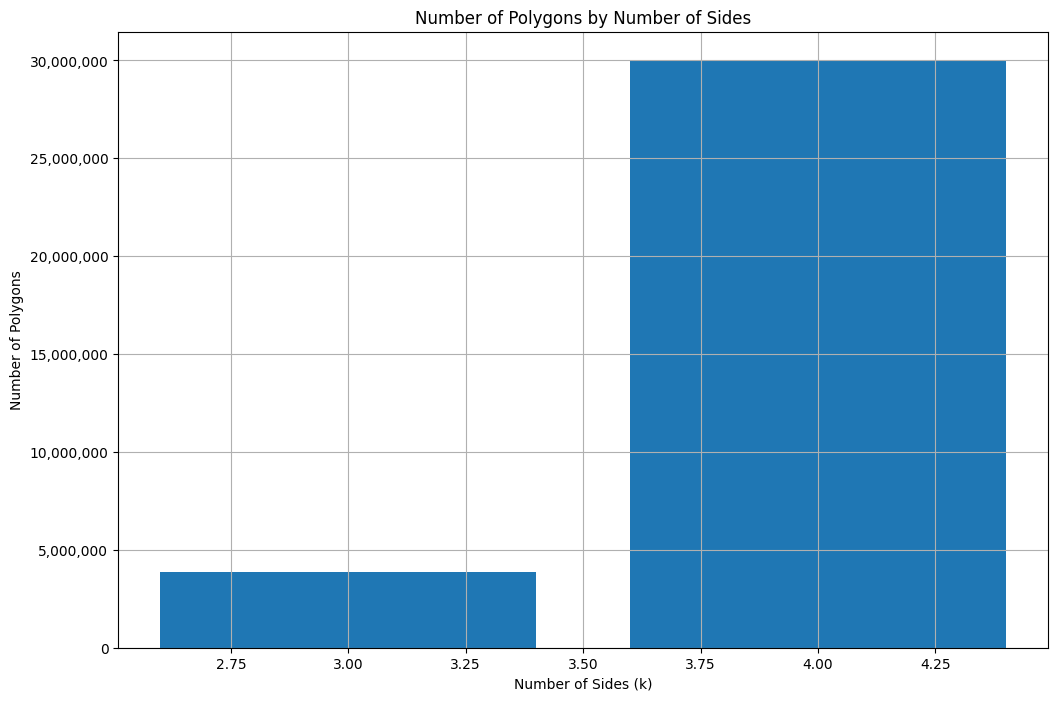

In [66]:
def count_polygons_of_length_k(graph: Graph, k: int) -> int: #TARDA 4 MINUTOS EN CORRER
    polygons = 0
    vertices = graph.get_vertices()
    neighbors = {vertex: set(graph.get_neighbors(vertex)) for vertex in vertices}

    def dfs(vertex, start, depth):
        nonlocal polygons
        if depth == k:
            if start in neighbors[vertex]:
                polygons += 1
            return
        for neighbor in neighbors[vertex]:
            if neighbor not in visited:
                visited.add(neighbor)
                dfs(neighbor, start, depth + 1)
                visited.remove(neighbor)

    for vertex in vertices:
        visited = {vertex}
        dfs(vertex, vertex, 1)

    return polygons // k

def count_polygons_up_to_k(graph: Graph, max_k: int) -> Dict[int, int]:
    polygons_count = {}
    
    for k in range(3, max_k + 1):    
        polygons_count[k] = count_polygons_of_length_k(graph, k)
    
    return polygons_count

def plot_polygons_count(polygons_count: Dict[int, int], max_k: int):
    x = list(polygons_count.keys())
    y = list(polygons_count.values())
    
    plt.figure(figsize=(12, 8))
    if max_k <= 5:
        plt.bar(x, y)
    else:
        plt.plot(x, y, marker='o')
    
    plt.xlabel('Number of Sides (k)')
    plt.ylabel('Number of Polygons')
    plt.title('Number of Polygons by Number of Sides')
    plt.grid(True)
    
    # Customize the y-axis to show numbers in full
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    plt.show()

max_k = 4

polygons_count = count_polygons_up_to_k(page_graph, max_k)
plot_polygons_count(polygons_count, max_k)


- Como podemos ver en el gráfico, la cantidad de polígonos de $K$ lados crece exponencialmente con K. Por lo que que calcular la cantidad de poligonos para $K > 4$ sería muy costoso computacionalmente.

## 2) Calcule el coeficiente de clustering del grafo 

- El coeficiente de clustering de un grafo es una medida de cuánto se agrupan los vértices en el grafo. Se calcula como el promedio de los coeficientes de clustering de cada vértice. El coeficiente de clustering de un vértice es la cantidad de aristas entre los vecinos del vértice dividido la cantidad de aristas posibles entre los vecinos del vértice.

$$ \text{Coeficiente de Clustering} = \frac{1}{|V|} \sum_{i=1}^{|V|} \frac{\text{Cantidad de aristas entre los vecinos de } V_{i}}{\text{Cantidad de aristas posibles entre los vecinos de } V_{i}}$$

In [67]:
def clustering_coefficient(graph, vertex):
    neighbors = graph.get_neighbors(vertex)
    degree = len(neighbors)
    
    if degree < 2:
        return 0.0
    
    possible_connections = degree * (degree - 1) / 2
    actual_connections = 0
    
    neighbor_set = set(neighbors)
    for neighbor1, neighbor2 in combinations(neighbor_set, 2):
        if graph.edge_exists(neighbor1, neighbor2):
            actual_connections += 1
    
    return actual_connections / possible_connections

def average_clustering_coefficient(graph):
    vertices = graph.get_vertices()
    clustering_coefficients = [clustering_coefficient(graph, vertex) for vertex in vertices]
    return sum(clustering_coefficients) / len(vertices)


print(f"El coeficiente de clustering promedio sobre el grafo diriguido es: {average_clustering_coefficient(page_graph)}")

El coeficiente de clustering promedio sobre el grafo diriguido es: 0.3668182309605963


## 3) ¿cuál es el vértice con más betweenness centrality?

- La betweenness centrality de un vértice es una medida de cuánto pasa por ese vértice en los caminos más cortos entre otros vértices. Se calcula como la cantidad de caminos más cortos que pasan por el vértice dividido la cantidad de caminos más cortos posibles.

$$ \text{Betweenness Centrality} = \frac{\text{Cantidad de caminos más cortos que pasan por } V_{i}}{\text{Cantidad de caminos más cortos posibles}}$$

In [68]:
def bfs(graph, start):      
    """bfs all the graph from start vertex"""
    queue = deque()
    queue.append(start)
    visited = set()
    visited.add(start)
    previous = {start: (None,0)}  
    while queue:
        current = queue.popleft()
        for neighbor in graph.get_neighbors(current):
            if neighbor not in visited:
                queue.append(neighbor)
                visited.add(neighbor)
                
                previous[neighbor] = (current, previous[current][1] + 1)

    return previous

def calculate_path(previous_dict, start, end):
    """calculate path between two nodes from a previous dict"""
    path = []
    node = end
    while node != start:
        path.append(node)
        node = previous_dict[node][0]
    path.append(start)
    path.reverse()
    return path

def betweenness_centrality(graph, steps):
    passes_by = {}

    for _ in tqdm(range(steps)):
        start_nodo = random.choice(list(graph.get_vertices()))

        shortest_paths = bfs(graph, start_nodo)

        for target in shortest_paths.keys():
            if shortest_paths[target][1] == float('inf') or target == start_nodo:
                continue
            path = calculate_path(shortest_paths, start_nodo , target)
        
            if not path:
                continue
            for vertex in path[3:]:
                passes_by[vertex] = passes_by.get(vertex, 0) + 1

    return passes_by

print("Calculando betweenness centrality")
betweenness = betweenness_centrality(page_graph, 10)
print("Betweenness centrality calculado")
print("Top 10 vértices con mayor betweenness centrality")
top_betweenness = heapq.nlargest(10, betweenness, key=betweenness.get)
for i, vertex in enumerate(top_betweenness):
    print(f"{i+1}. {vertex} - Betweenness Centrality: {betweenness[vertex]}")


# 1. 560622 - Betweenness Centrality: 48088964  Este es NODO CON MAS BETWEENNESS CENTRALITY

Calculando betweenness centrality


100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Betweenness centrality calculado
Top 10 vértices con mayor betweenness centrality
1. 560622 - Betweenness Centrality: 605800
2. 39469 - Betweenness Centrality: 531501
3. 461260 - Betweenness Centrality: 467133
4. 464313 - Betweenness Centrality: 434739
5. 382048 - Betweenness Centrality: 425644
6. 165367 - Betweenness Centrality: 348361
7. 792025 - Betweenness Centrality: 346544
8. 204448 - Betweenness Centrality: 341936
9. 26922 - Betweenness Centrality: 272106
10. 330762 - Betweenness Centrality: 240880
